# Parallelising array operations with `dask`

The [`dask`](https://dask.org/) package provides parallelised operations for speeding up array operations with `numpy`, `pandas`, and `scikit-learn`. It can distribute operations over a cluster, or multiple cores on a single machine, and enables the use of very large arrays in a smaller memory footprint.

In [1]:
# Import packages
import dask
import numpy as np

from dask import array as da

## Speeding up a `numpy` calculation

As a first example, we'll calculate some basic operations on `numpy` arrays, then parallelise with `dask`. Firstly, we declare an array with random values.

In [2]:
# Declare 10000x10000 random array
arr = np.random.rand(10000, 10000)

Now we'll time how long it takes to calculate some statistical measures:

In [3]:
%%timeit

mean = arr.mean()
std = arr.std()
moment = (arr * arr * arr).mean()
skewness = (moment - (3 * mean * std ** 2) - mean ** 3) / (std ** 3)

1.22 s ± 43 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


This is acceptably fast on my laptop, about 1s for each loop.

Let's convert the `numpy` array to a `dask` array in chunks. This would let us perform calculations on arrays that would otherwise be too large to fit in memory.

In [4]:
darr = da.from_array(arr, chunks=(5000, 5000))

In [5]:
%%timeit

da_mean = darr.mean()
da_std = darr.std()
da_moment = da.mean(darr * darr * darr)
da_skewness = (da_moment - (3 * da_mean * da_std ** 2) - da_mean ** 3) / (da_std ** 3)

3.47 ms ± 171 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


This is much faster, at 3ms per loop, even with the chunk being the same size as the original data array. This is, in part because the result has not yet been calculated - we just have the `dask` collection as the result of each calculation. We can see this by repeating the run with a call to `dask.compute()` on each cycle:

In [6]:
%%timeit

da_mean = darr.mean()
da_std = darr.std()
da_moment = da.mean(darr * darr * darr)
da_skewness = (da_moment - (3 * da_mean * da_std ** 2) - da_mean ** 3) / (da_std ** 3)
dask.compute(da_mean, da_std, da_moment, da_skewness)

641 ms ± 19.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Computing at the end of the run is often faster than computing each result as we go (lower overheads):

In [7]:
%%timeit

da_mean = darr.mean().compute()
da_std = darr.std().compute()
da_moment = da.mean(darr * darr * darr).compute()
da_skewness = (da_moment - (3 * da_mean * da_std ** 2) - da_mean ** 3) / (da_std ** 3)

789 ms ± 23 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


We can use arguments to the `.compute()` function to modify performance:

In [8]:
%%timeit

da_mean = darr.mean()
da_std = darr.std()
da_moment = da.mean(darr * darr * darr)
da_skewness = (da_moment - (3 * da_mean * da_std ** 2) - da_mean ** 3) / (da_std ** 3)
dask.compute(da_mean, da_std, da_moment, da_skewness, scheduler="single-threaded")

1.86 s ± 25.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [9]:
%%timeit

da_mean = darr.mean()
da_std = darr.std()
da_moment = da.mean(darr * darr * darr)
da_skewness = (da_moment - (3 * da_mean * da_std ** 2) - da_mean ** 3) / (da_std ** 3)
dask.compute(da_mean, da_std, da_moment, da_skewness, num_workers=3)

1.01 s ± 15.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Are the results the same?

It's all very well being faster, but do we get the same result with `numpy` and `dask`?

In [10]:
%time

# Calculate with numpy
mean = arr.mean()
std = arr.std()
moment = (arr * arr * arr).mean()
skewness = (moment - (3 * mean * std ** 2) - mean ** 3) / (std ** 3)

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 7.15 µs


In [11]:
%time

# Calculate with dask
da_mean = darr.mean().compute()
da_std = darr.std().compute()
da_moment = da.mean(darr * darr * darr).compute()
da_skewness = (da_moment - (3 * da_mean * da_std ** 2) - da_mean ** 3) / (da_std ** 3)

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 6.91 µs


In [12]:
print("mean diff: {:.8f}".format(da_mean - mean))
print("std diff: {:.8f}".format(da_std - std))
print("moment diff: {:.8f}".format(da_moment - moment))
print("skewness diff: {:.8f}".format(da_skewness - skewness))

mean diff: -0.00000000
std diff: -0.00000000
moment diff: 0.00000000
skewness diff: 0.00000000


## Visualising the task graph

The operations being parallelised can be visualised using `graphviz`, if this is installed.

We can see the operations being carried out in our `.mean()` operation:

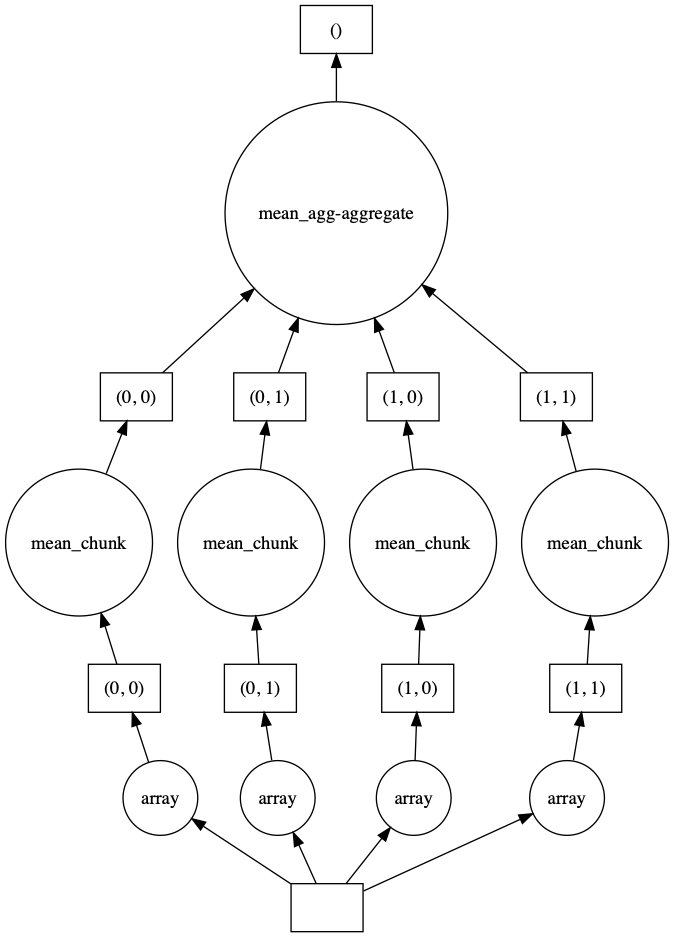

In [13]:
# visualise task graph for calculating the mean with dask
darr.mean().visualize()

For a different matrix operation:

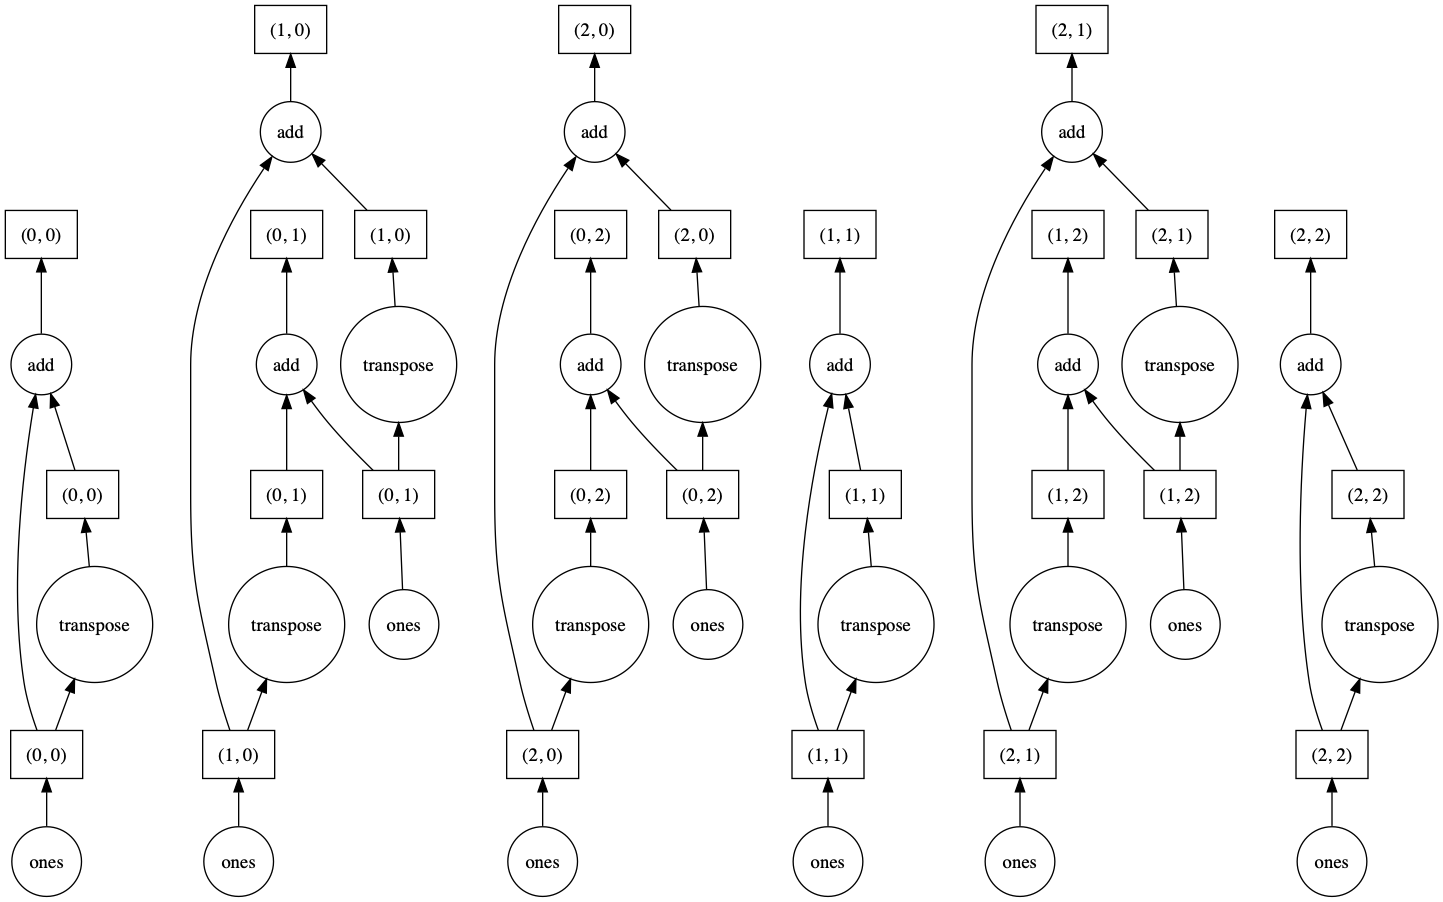

In [14]:
# create 15x15 array of 1s
x = da.ones((15, 15), chunks=(5, 5))

# addition and transpose
y = x + x.T

# visualise
y.visualize()

In [15]:
# show result
y.compute()

array([[2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
       [2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
       [2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
       [2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
       [2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
       [2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
       [2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
       [2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
       [2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
       [2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
       [2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
       [2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
       [2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
       [2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
       [2., 2., 2., 2., 2., 2., 2.

## Creating large arrays

On my laptop, generating a 1e6 x 1e6 `numpy` random array is too memory-hungry to complete. Using the `dask` array creation process allows us to create and work with very large arrays that would otherwise be unmanageable. The array creation below doesn't even complete on my laptop in the time shown here, if carried out with `numpy`.

In [16]:
%%timeit

# Create 1e5 x 1e5 random array
rand_arr = da.random.random((100000, 100000), chunks=(10000, 10000))
rand_arr.mean().compute()

20.2 s ± 672 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
